In [25]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

import datetime
import os

import tensorflow as tf
print(tf.__version__)

import tensorflow_addons as tfa
print(tfa.__version__)

2.4.1
0.12.1


In [26]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import glob
import os

import phenom

import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

# from cycler import cycler
# from itertools import cycle

# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use("ggplot")
# mpl.rcParams.update({"font.size": 16})

import multiprocessing as mp
import functools

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import wispy.lalutils
import wispy.model_utils
import wispy.callbacks
import wispy.resnet

import lalsimulation as lalsim

from sklearn.preprocessing import MinMaxScaler

In [109]:
import pugna.layers
import pugna.activations
import pugna.callbacks

from tensorflow.keras.utils import get_custom_objects
# https://stackoverflow.com/a/59789336/12840171
# this is the way to add custome activations - do not do 
# get_custom_objects().update({'srelu': tf.keras.layers.Activation(pugna.activations.sReLU)})
# get_custom_objects().update({'s2relu': tf.keras.layers.Activation(pugna.activations.s2relu)})
# instead to
# otherwise problems with saving and loading
get_custom_objects().update({'srelu': pugna.activations.sReLU})
get_custom_objects().update({'s2relu': pugna.activations.s2relu})

In [110]:
plt.style.use("ggplot")
mpl.rcParams.update({"font.size": 16})

In [111]:
def compute_fft(x, y):
    """
    function to compute the fourier transform and sample frequencies.
    only keeping the positive side of the fft and normalising.
    """
    N = len(x)
    dt = x[1] - x[0]
    
    yf = 2.0/N * np.fft.fft(y)[:N//2]
    xf = np.fft.fftfreq(N, dt)[:N//2]

    return xf, yf

# define model

In [112]:
# need a function to create sub-networks
def build_subnetwork(input_tensor, units, activation='relu', n_blocks=1):
    """
    n_blocks >= 1
    """
    assert n_blocks >= 1, f"n_blocks must be >1, got {n_blocks}"

    # tmp = input_tensor
    tmp = tf.keras.layers.Dense(units, activation=activation)(input_tensor)

    x = tf.keras.layers.Dense(units, activation=activation)(input_tensor)
    # x = tfa.layers.GroupNormalization(groups=1)(x)
    # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)
    for _ in range(n_blocks):
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        x = tf.keras.layers.Dense(units, activation=activation)(x)
        # x = tfa.layers.GroupNormalization(groups=1)(x)
        # x = tf.keras.layers.BatchNormalization(momentum=0.9)(x)

        x = tf.keras.layers.add([x, tmp])
        tmp = x

    # single output here?
    x = tf.keras.layers.Dense(1, activation='linear')(x)

    return x

In [113]:
# constant scale
class ScaleLayer(tf.keras.layers.Layer):
    def __init__(self, scale, **kwargs):
        super(ScaleLayer, self).__init__()
        self.scale = scale
        
    def call(self, inputs):
        return inputs * self.scale
    
    def get_config(self):
        config = super(ScaleLayer, self).get_config()
        config.update({"scale": self.scale})
        return config


In [114]:
# uses scale * (1+delta_w) where delta_w is trainable
class ScaleLayer_Trainable(tf.keras.layers.Layer):
    def __init__(self, scale, name=None, **kwargs):
        super(ScaleLayer_Trainable, self).__init__(name=name)
        self.scale = scale
        
    def build(self, input_shape):
        self.delta_w = self.add_weight(shape=(input_shape[-1], 1), initializer=tf.keras.initializers.RandomNormal(), trainable=True, name="delta_w")
        
    def call(self, inputs):
        return inputs * self.scale * (1. + self.delta_w)

In [115]:
# uses a random, trainable scale
class ScaleLayer_Trainable_v2(tf.keras.layers.Layer):
    def __init__(self, name=None, **kwargs):
        super(ScaleLayer_Trainable_v2, self).__init__(name=name)
        
    def build(self, input_shape):
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer=tf.keras.initializers.RandomUniform(0, 100), trainable=True, name="delta_w")
        
    def call(self, inputs):
        return inputs * self.scale

In [116]:
TEST_X = tf.convert_to_tensor([[1.],[2.],[3.]])

In [117]:
TEST_X

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [118]:
tmp2=ScaleLayer_Trainable(10)
tmp2(TEST_X)
print(tmp2.delta_w)
print(tmp2.scale*(1.+tmp2.delta_w))

<tf.Variable 'scale_layer__trainable_4/delta_w:0' shape=(1, 1) dtype=float32, numpy=array([[0.0688102]], dtype=float32)>
tf.Tensor([[10.688103]], shape=(1, 1), dtype=float32)


In [119]:
ScaleLayer_Trainable(1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[0.95559657],
       [1.9111931 ],
       [2.8667898 ]], dtype=float32)>

In [120]:
ScaleLayer(1)(TEST_X)

<tf.Tensor: shape=(3, 1), dtype=float32, numpy=
array([[1.],
       [2.],
       [3.]], dtype=float32)>

In [121]:
# this version supports variable number of units and blocks for each scale.
# the idea is that maybe smaller scales can cope with smaller networks
def build_model(
    input_shape = 1,
    output_shape = 1,
    units = [128],
    activation = 'relu',
    n_blocks = [2],
    scales = [1]
    ):
    assert len(scales) == len(n_blocks) == len(units), "units, n_blocks, scales must have same length"

    input_layer = tf.keras.Input(shape=(input_shape,))

    # create sub-networks
    xs = []
    for i, scale in enumerate(scales):
        scaled_input = ScaleLayer(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable(scale)(input_layer)
#         scaled_input = ScaleLayer_Trainable_v2()(input_layer)
        xs.append(build_subnetwork(scaled_input, units[i], activation, n_blocks[i]))

    if len(xs) > 1:
        output_layer = tf.keras.layers.add([x for x in xs])
    else:
        output_layer = xs[0]

    output_layer = tf.keras.layers.Dense(output_shape, activation="linear")(output_layer)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model

In [122]:
def get_compiled_model(
        input_shape = 1,
        output_shape = 1,
        units = 128,
        n_blocks = 1,
        scales = [1],
        activation = 'relu',
        lr=1e-3,
        loss='mse',
        metrics=None
    ):
    model = build_model(
        input_shape=input_shape,
        output_shape=output_shape,
        units=units,
        activation=activation,
        n_blocks=n_blocks,
        scales=scales
        )

    optimizer = tf.keras.optimizers.Adam(lr)

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return model

# data generator

In [41]:
def gen_data_2d_s1x_time(s1x_min, s1x_max, s1x_num, q=1, M=100, nproc=1, t_min=-500, validation=False, val_time_random=False, val_time_size=100):

    s1x_arr = np.linspace(s1x_min, s1x_max, s1x_num)

    ps = []
    for s1x in s1x_arr:
        m1, m2 = phenom.m1_m2_M_q(M, q)
        ps.append(wispy.lalutils.gen_td_wf_params(m1=m1, m2=m2, S1x=s1x, approximant=lalsim.SEOBNRv4P, f_min=5, distance=1e6))

    times = []
    amp = []
    phase = []

    func = functools.partial(wispy.lalutils.gen_td_wf, t_max=40, t_min=t_min)

    with mp.Pool(nproc) as pool:
        returned = pool.map(func, ps)
#     print(len(returned))
#     print(len(returned[0]))
#     print(returned[0])
    for i in range(len(returned)):
        times.append(returned[i][0])
        amp.append(returned[i][1])
        phase.append(returned[i][2])



    # find common times and interpolate data onto common time grid
    dt_M = 0.5
    common_tmin = np.max(list(map(np.min, times)))
    common_tmax = np.min(list(map(np.max, times)))

    print(f"common_tmin = {common_tmin}")
    print(f"common_tmax = {common_tmax}")

    common_times = np.arange(common_tmin, common_tmax, dt_M)
    if validation is True:
        if val_time_random:
            if val_time_size is None:
                val_time_size=len(common_times)
            common_times = np.random.uniform(low=common_tmin, high=common_tmax, size=val_time_size)

    ntimes = len(common_times)
    print(f"ntimes = {ntimes}")

    n_cases = len(ps)

    amps = np.zeros(shape=(n_cases, ntimes))
    phases = np.zeros(shape=(n_cases, ntimes))

    for i in range(n_cases):
        amps[i] = IUS(times[i], amp[i])(common_times)
        phases[i] = IUS(times[i], phase[i])(common_times)

    return common_times, amps, phases, s1x_arr



In [188]:
def convert_input_for_ann(times, q):
    times = np.atleast_1d(times)
    q = np.atleast_1d(q)
    XX, YY = np.meshgrid(times, q)
    X = np.stack((XX.ravel(), YY.ravel()), axis=1) #axis=1 is same as column_stack

    return X

def compute_pre_process(ys):
    ys = ys.copy()
    ys_mean = np.mean(ys, axis=0)[np.newaxis, :] # mean waveform
    ys -= ys_mean
    ys_max = np.max(ys)

    return ys_mean, ys_max

def apply_pre_process_forward(ys, y_mean ,y_max):
    ys = ys.copy()
    ys -= y_mean
    ys /= y_max

    return ys

def apply_pre_process_reverse(ys, y_mean ,y_max):
    ys = ys.copy()
    ys *= y_max
    ys += y_mean

    return ys

In [189]:
def evaluate(s1x, model, times):
    xx = convert_input_for_ann(times, np.atleast_1d(s1x))
    
    return model.predict(xx).T

In [44]:
%%time
# common_times, amps, phases, s1x_arr = gen_data_2d_s1x_time(s1x_min=0, s1x_max=0.99, s1x_num=20, q=3, M=100, nproc=2, t_min=-500)
common_times, amps, phases, s1x_arr = gen_data_2d_s1x_time(s1x_min=0, s1x_max=0.99, s1x_num=5, q=3, M=100, nproc=2, t_min=-500)

common_tmin = -499.65485542229254
common_tmax = 39.57700617851138
ntimes = 1079
CPU times: user 13.4 ms, sys: 15.6 ms, total: 29 ms
Wall time: 7.35 s


In [45]:
%%time
common_times_val, amps_val, phases_val, s1x_arr_val = gen_data_2d_s1x_time(s1x_min=0.1, s1x_max=0.98, s1x_num=5, q=3, M=100, nproc=2, t_min=-500, validation=True, val_time_random=False, val_time_size=None)

common_tmin = -499.5972817208031
common_tmax = 39.51974995805577
ntimes = 1079
CPU times: user 13 ms, sys: 13.1 ms, total: 26.1 ms
Wall time: 8.05 s


In [190]:
common_times.shape

(1079,)

In [191]:
common_times_val.shape

(1079,)

In [192]:
y_mean, y_max = compute_pre_process(amps)

amps_prime = apply_pre_process_forward(amps, y_mean, y_max)

# scale times to between -1, 1
times_scaler = MinMaxScaler(feature_range=(-1,1)) # this works better than (0,1)
# times_scaler = MinMaxScaler(feature_range=(0,1))
common_times_scaled = times_scaler.fit_transform(common_times[:, np.newaxis])[:,0]

# X = convert_input_for_ann(common_times, s1x_arr)
X = convert_input_for_ann(common_times_scaled, s1x_arr)
y = amps_prime.ravel().reshape(-1, 1)

common_times_scaled_val = times_scaler.transform(common_times_val[:,np.newaxis])[:,0]

# X_val = convert_input_for_ann(common_times, s1x_arr_val)
X_val = convert_input_for_ann(common_times_scaled, s1x_arr_val)


# need to do this if the validation times are not on the same grid
if len(common_times) != len(common_times_val):
    y_mean_val_interpolated = IUS(common_times, y_mean[0])(common_times_val).reshape(1, -1)
    y_mean_val = y_mean_val_interpolated
else:
    y_mean_val = y_mean.copy()

amps_val_prime = apply_pre_process_forward(amps_val, y_mean_val, y_max)


y_val = amps_val_prime.ravel().reshape(-1, 1)

# training data X and y

print(f"num cases: {s1x_arr.shape}")

print(f"X.shape = {X.shape}")
print(f"y.shape = {y.shape}")

# validation data X and y

print(f"num cases: {s1x_arr_val.shape}")

print(f"X_val.shape = {X_val.shape}")
print(f"y_val.shape = {y_val.shape}")


## single case
single_case = {}
index = 0
single_case['index'] = index
single_case['s1x'] = s1x_arr[index]
single_case['X'] = convert_input_for_ann(common_times_scaled, s1x_arr[index])
single_case['y'] = amps_prime[index].ravel().reshape(-1, 1)
print(f"single_case['X'].shape: {single_case['X'].shape}")
print(f"single_case['y'].shape: {single_case['y'].shape}")

num cases: (5,)
X.shape = (5395, 2)
y.shape = (5395, 1)
num cases: (5,)
X_val.shape = (5395, 2)
y_val.shape = (5395, 1)
single_case['X'].shape: (1079, 2)
single_case['y'].shape: (1079, 1)


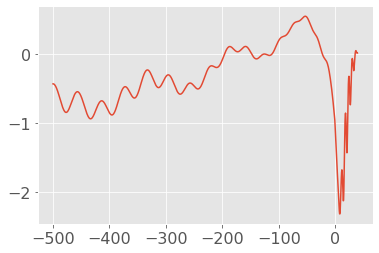

In [193]:
plt.figure()
# plt.plot(common_times, amps[-1])
# plt.plot(common_times, y_mean[0])
plt.plot(common_times, amps_prime[-1])

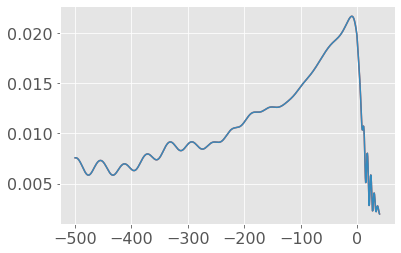

In [236]:
plt.figure()
plt.plot(common_times, amps[-1])
# plt.plot(common_times, y_mean[0])
plt.plot(common_times, apply_pre_process_reverse(amps_prime, y_mean, y_max)[-1])

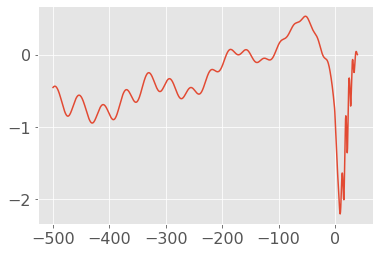

In [194]:
plt.figure()
# plt.scatter(common_times_val, amps_val[-1])
# plt.scatter(common_times_scaled_val, amps_val[-1])
plt.plot(common_times_val, amps_val_prime[-1])

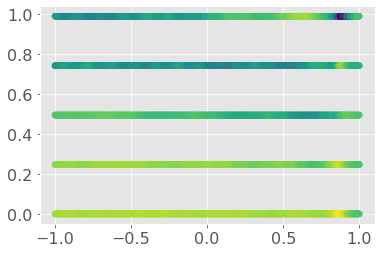

In [195]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)

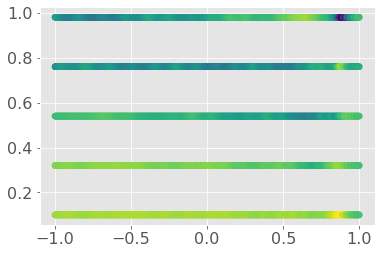

In [196]:
plt.figure()
plt.scatter(X_val[:,0], X_val[:,1], c=y_val)

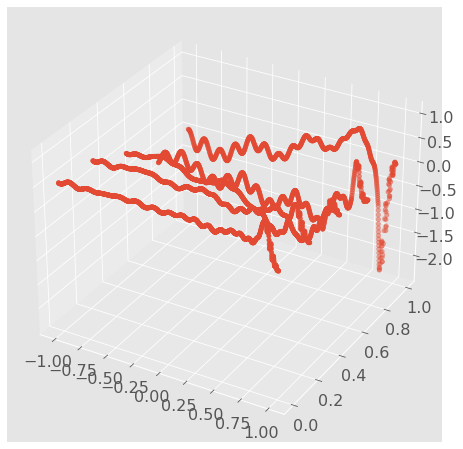

In [197]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
# ax.view_init(45, 35)
ax.scatter(X[:,0], X[:,1], y[:,0])

In [198]:
# sample_weight

In [199]:
X.shape

(5395, 2)

In [200]:
# mask = (X[:,0] > 0.7) & (X[:,1] > 0.6)
mask = (X[:,0] > 0.7)

In [201]:
mask

array([False, False, False, ...,  True,  True,  True])

In [202]:
X[mask]

array([[0.7012987 , 0.        ],
       [0.70315399, 0.        ],
       [0.70500928, 0.        ],
       ...,
       [0.99628942, 0.99      ],
       [0.99814471, 0.99      ],
       [1.        , 0.99      ]])

In [203]:
sample_weight = np.ones(len(X))
sample_weight[mask] = 10

In [204]:
sample_weight

array([ 1.,  1.,  1., ..., 10., 10., 10.])

In [205]:
sample_weight.shape

(5395,)

In [206]:
X.shape

(5395, 2)

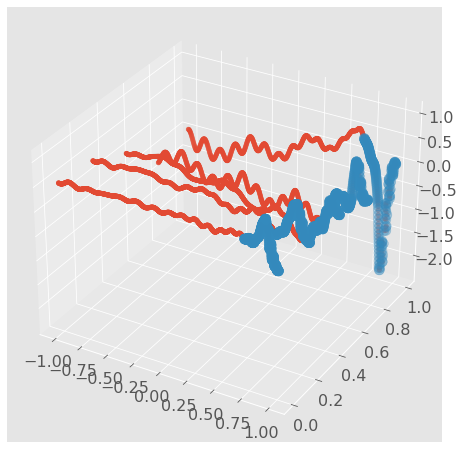

In [207]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
# ax.view_init(45, 35)
ax.scatter(X[:,0], X[:,1], y[:,0])
ax.scatter(X[:,0][mask], X[:,1][mask], y[:,0][mask], s=100)

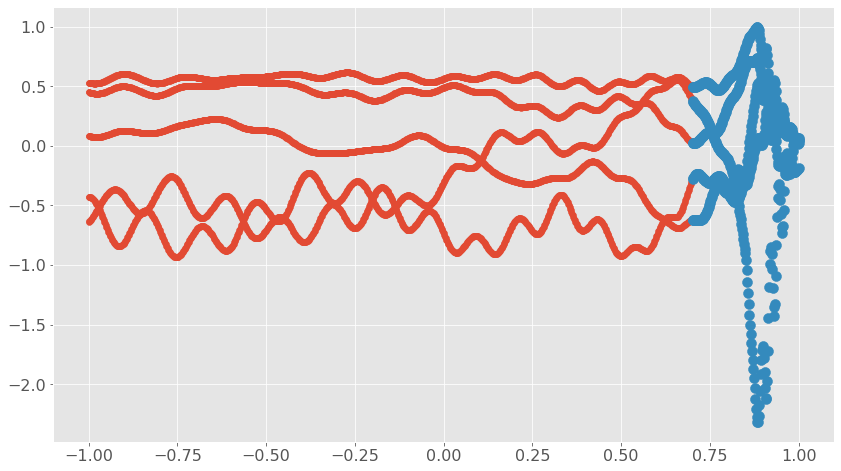

In [208]:
fig = plt.figure(figsize=(14, 8))
# ax.view_init(45, 35)
plt.scatter(X[:,0], y[:,0])
plt.scatter(X[:,0][mask], y[:,0][mask], s=100)

# fit

In [378]:
input_shape = X.shape[1]
output_shape = y.shape[1]
# units = [64, 256, 256]
# n_blocks = [1, 2, 2]
# scales = [1,10,100]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [1]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [10]
# activation = 's2relu'

units = [256]
n_blocks = [2]
scales = [10]
activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [100]
# activation = 's2relu'


# units = [128,128,128,128]
# n_blocks = [1,1,1,1]
# scales = [1,10,10,10]
# activation = 's2relu'


# scales = [1]
# activation='relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [379]:
model = get_compiled_model(
    input_shape=input_shape, output_shape=output_shape, units=units,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

model.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_29 (ScaleLayer)     (None, 2)            0           input_15[0][0]                   
__________________________________________________________________________________________________
dense_141 (Dense)               (None, 256)          768         scale_layer_29[0][0]             
__________________________________________________________________________________________________
dense_142 (Dense)               (None, 256)          65792       dense_141[0][0]                  
___________________________________________________________________________________________

In [380]:
# tf.keras.utils.plot_model(model)

In [381]:
# epochs = 200
# epochs = 600
epochs = 4000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=40, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
# callbacks = [reduce_lr, PrintDot()]
callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 5395


In [382]:
starttime = datetime.datetime.now()

history = model.fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=sample_weight
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

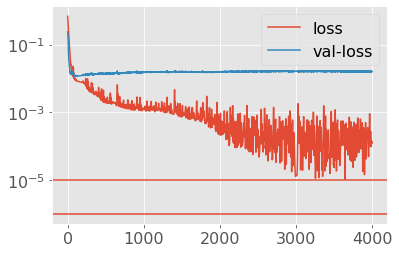

In [383]:
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6)

if 'lr' in history.history.keys():
    plt.figure()
    plt.plot(history.history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

In [384]:
model.layers[1].name

'scale_layer_29'

In [385]:
for layer in model.layers:
    if "scale" in layer.name:
        print(layer.scale)

10


s1x: 0.0


(-10.0, 40.0)

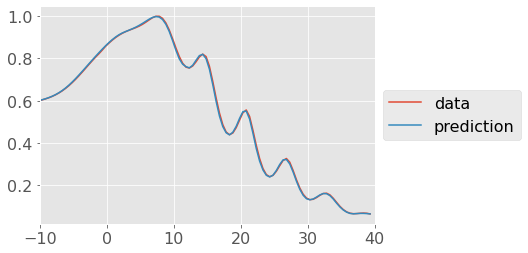

In [386]:
index=0
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
plt.figure()
# plt.plot(common_times_scaled, amps_prime[index], label='data')
# plt.plot(common_times_scaled, yhat[0], label='prediction')
plt.plot(common_times, amps_prime[index], label='data')
plt.plot(common_times, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-10, 40)

s1x: 0.99


(-10.0, 40.0)

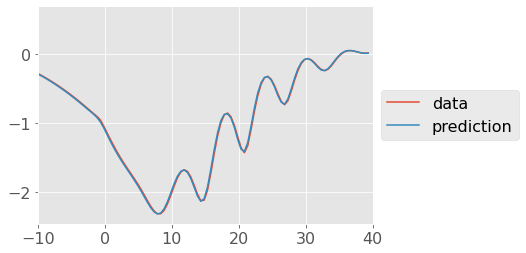

In [387]:
index=-1
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
plt.figure()
# plt.plot(common_times_scaled, amps_prime[index], label='data')
# plt.plot(common_times_scaled, yhat[0], label='prediction')
plt.plot(common_times, amps_prime[index], label='data')
plt.plot(common_times, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-10, 40)

s1x: 0.54


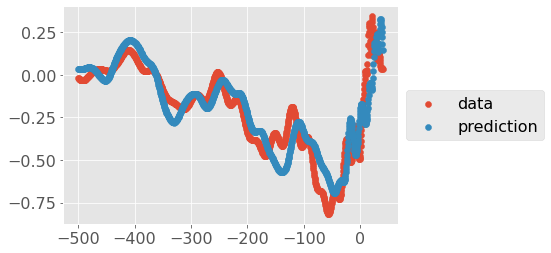

In [388]:
index=-3
print(f"s1x: {s1x_arr_val[index]}")
yhat = evaluate(s1x_arr_val[index], model, times=common_times_scaled_val)
plt.figure()
# plt.scatter(common_times_scaled_val, amps_val_prime[index], label='data')
# plt.scatter(common_times_scaled_val, yhat[0], label='prediction')
plt.scatter(common_times_val, amps_val_prime[index], label='data')
plt.scatter(common_times_val, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 60)

s1x: 0.0


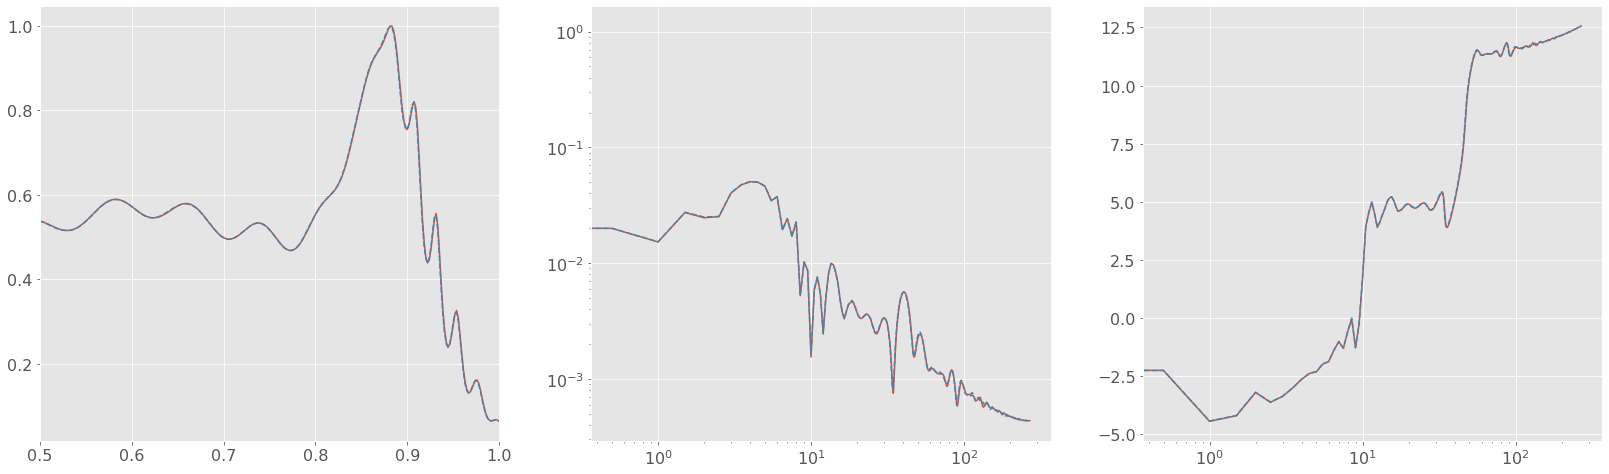

In [389]:
index=0
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
xf, yf = compute_fft(common_times_scaled, amps_prime[index])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[index], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(-10, 60)
plt.xlim(0.5, 1)

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

s1x: 0.2475


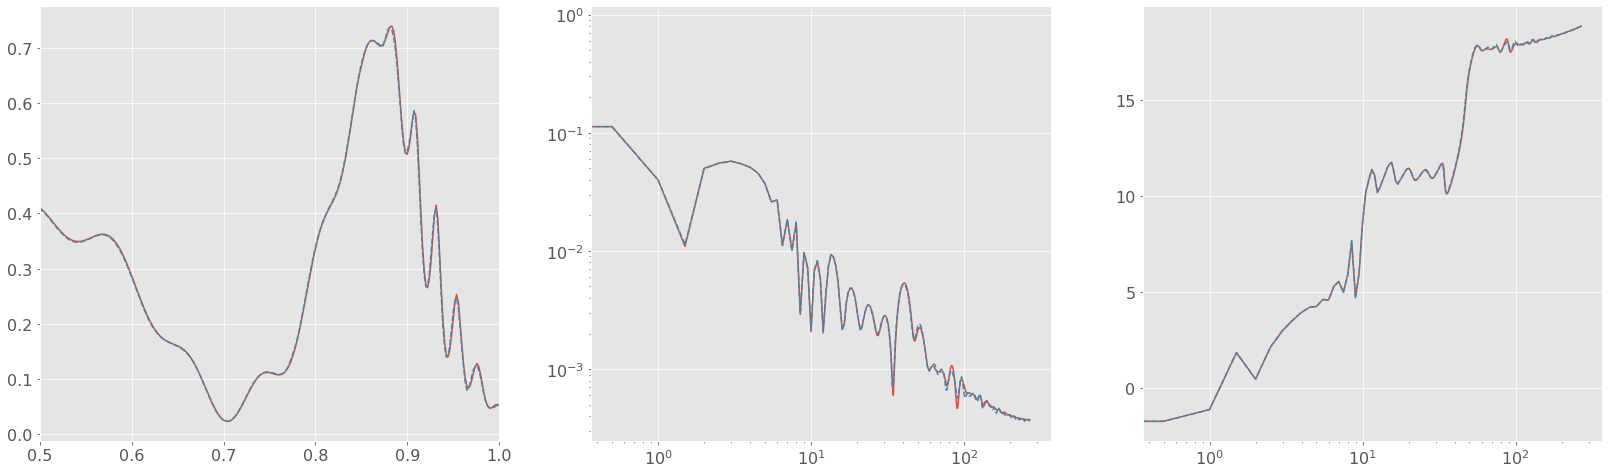

In [390]:
index=-4
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
xf, yf = compute_fft(common_times_scaled, amps_prime[index])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[index], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
plt.xlim(0.5, 1)

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

s1x: 0.99


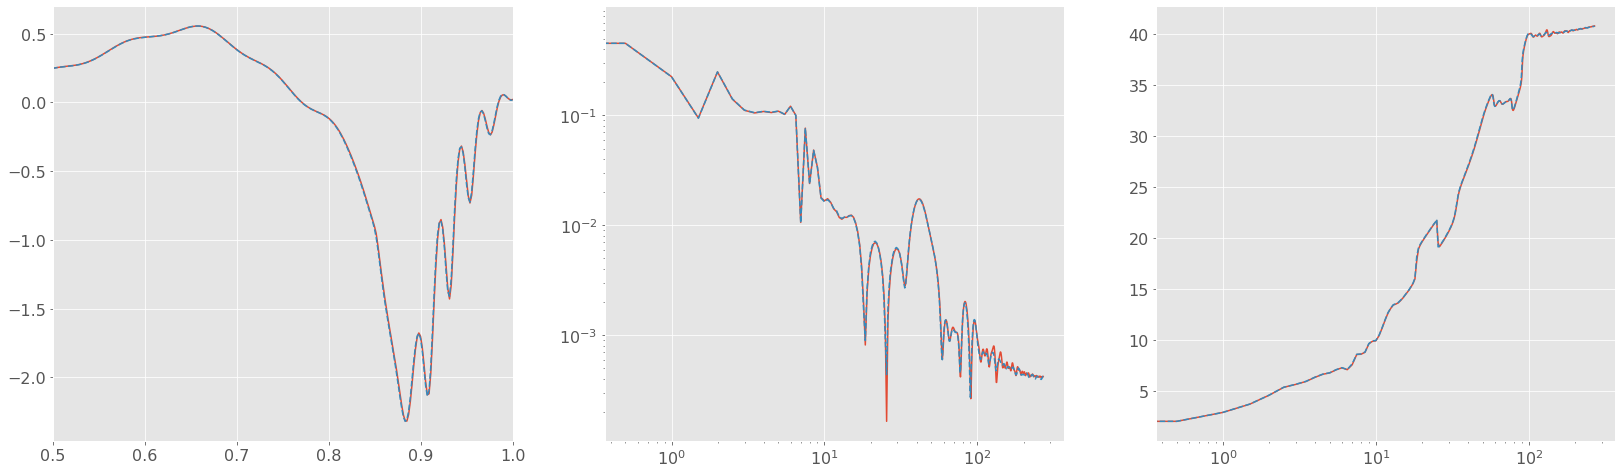

In [391]:
index=-1
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
xf, yf = compute_fft(common_times_scaled, amps_prime[index])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[index], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
plt.xlim(0.5, 1)

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

# need to run with very few waveforms or even just one waveform then continue training the model after its converged with larger and larger training sets

# fit single case

In [209]:
# single_case['mask'] = (single_case['X'][:,0] > 0.7) & (single_case['X'][:,1] > 0.6)
single_case['mask'] = (single_case['X'][:,0] > 0.7)

In [210]:
single_case['mask']

array([False, False, False, ...,  True,  True,  True])

In [214]:
# single_case['X'][single_case['mask']]

In [215]:
single_case['sample_weight'] = np.ones(len(single_case['X']))
single_case['sample_weight'][single_case['mask']] = 10

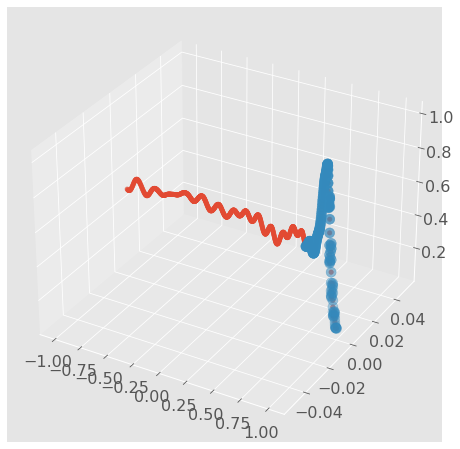

In [216]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(projection='3d')
# ax.view_init(45, 35)
ax.scatter(single_case['X'][:,0], single_case['X'][:,1], single_case['y'][:,0])
ax.scatter(single_case['X'][:,0][single_case['mask']], single_case['X'][:,1][single_case['mask']], single_case['y'][:,0][single_case['mask']], s=100)

# fit

In [282]:
input_shape = single_case['X'].shape[1]
output_shape = single_case['y'].shape[1]
# units = [64, 256, 256]
# n_blocks = [1, 2, 2]
# scales = [1,10,100]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [1]
# activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [10]
# activation = 's2relu'

units = [256]
n_blocks = [2]
scales = [10]
activation = 's2relu'

# units = [512]
# n_blocks = [1]
# scales = [100]
# activation = 's2relu'


# units = [128,128,128,128]
# n_blocks = [1,1,1,1]
# scales = [1,10,10,10]
# activation = 's2relu'


# scales = [1]
# activation='relu'

lr=1e-3
loss='mse'
# metrics=['mse']
metrics=None

In [287]:
single_case['model'] = get_compiled_model(
    input_shape=input_shape, output_shape=output_shape, units=units,
    scales=scales,
    activation=activation,
    n_blocks=n_blocks,
    lr=lr, loss=loss, metrics=metrics    
    )

single_case['model'].summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
scale_layer_22 (ScaleLayer)     (None, 2)            0           input_12[0][0]                   
__________________________________________________________________________________________________
dense_111 (Dense)               (None, 256)          768         scale_layer_22[0][0]             
__________________________________________________________________________________________________
dense_112 (Dense)               (None, 256)          65792       dense_111[0][0]                  
___________________________________________________________________________________________

In [288]:
# tf.keras.utils.plot_model(model)

In [289]:
# epochs = 200
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = single_case['X'].shape[0]
# batch_size = single_case['X'].shape[0]//2
# batch_size = single_case['X'].shape[0]//4
# batch_size = single_case['X'].shape[0]//8
# batch_size = single_case['X'].shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=40, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
# callbacks = [reduce_lr, PrintDot()]
callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 1079


In [290]:
starttime = datetime.datetime.now()

single_case['history'] = single_case['model'].fit(
    single_case['X'],
    single_case['y'],
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=single_case['sample_weight']
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [170]:
# tf.keras.models.save_model(single_case['model'], 'single_case_model.h5')
# new_model = tf.keras.models.load_model("single_case_model.h5", custom_objects={'ScaleLayer':ScaleLayer})

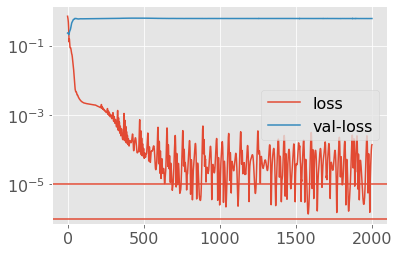

In [291]:
plt.figure()
plt.plot(single_case['history'].history['loss'], label='loss')
plt.plot(single_case['history'].history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6)

if 'lr' in single_case['history'].history.keys():
    plt.figure()
    plt.plot(single_case['history'].history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

s1x: 0.0


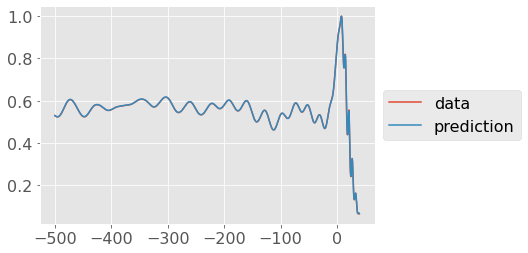

In [292]:
index=single_case['index']
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
plt.figure()
# plt.plot(common_times_scaled, amps_prime[index], label='data')
# plt.plot(common_times_scaled, yhat[0], label='prediction')
plt.plot(common_times, amps_prime[index], label='data')
plt.plot(common_times, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-10, 40)

s1x: 0.495


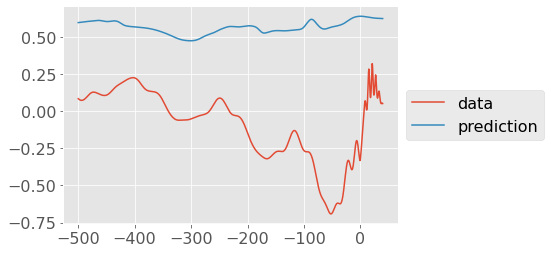

In [293]:
index=2
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
plt.figure()
# plt.plot(common_times_scaled, amps_prime[index], label='data')
# plt.plot(common_times_scaled, yhat[0], label='prediction')
plt.plot(common_times, amps_prime[index], label='data')
plt.plot(common_times, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-10, 40)

s1x: 0.54


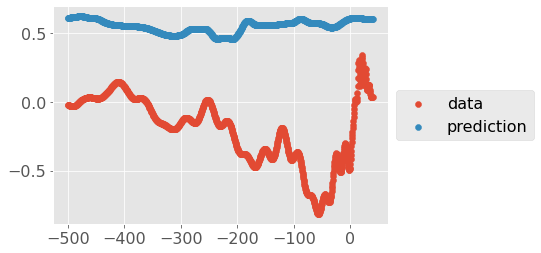

In [294]:
index=-3
print(f"s1x: {s1x_arr_val[index]}")
yhat = evaluate(s1x_arr_val[index], single_case['model'], times=common_times_scaled_val)
plt.figure()
# plt.scatter(common_times_scaled_val, amps_val_prime[index], label='data')
# plt.scatter(common_times_scaled_val, yhat[0], label='prediction')
plt.scatter(common_times_val, amps_val_prime[index], label='data')
plt.scatter(common_times_val, yhat[0], label='prediction')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 60)

In [295]:
index=single_case['index']
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
yhat = apply_pre_process_reverse(yhat, y_mean, y_max)

s1x: 0.0


In [296]:
yhat

array([[0.01118661, 0.01119071, 0.01119442, ..., 0.00232332, 0.00222632,
        0.00213792]], dtype=float32)

s1x: 0.0


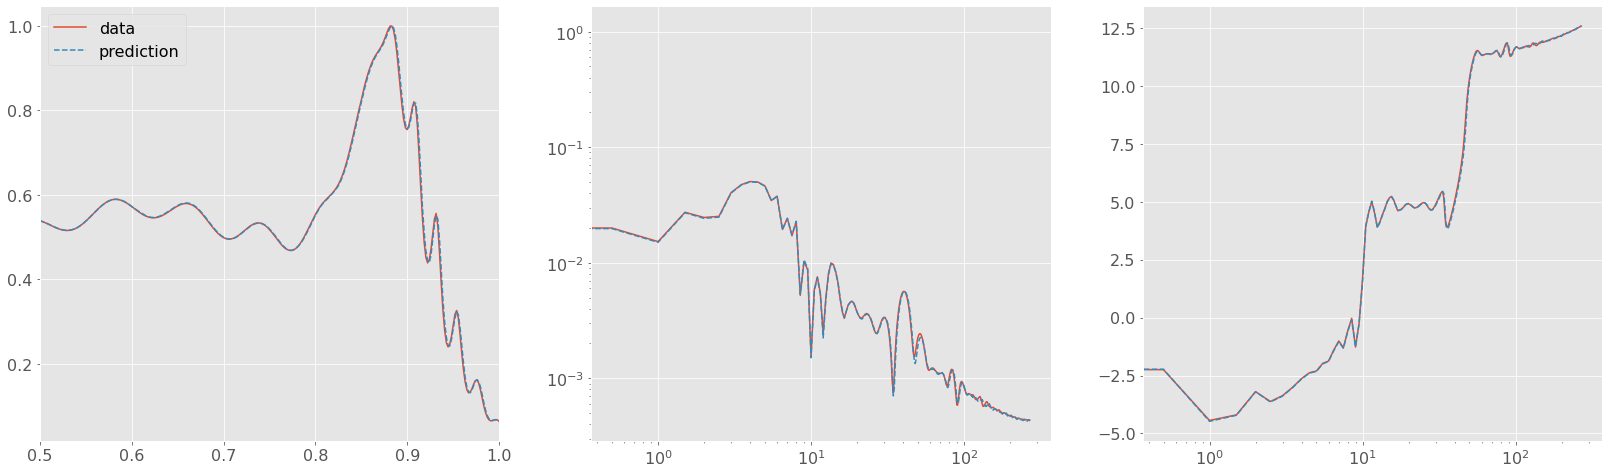

In [299]:
apply_reverse=False

index=single_case['index']
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)

if apply_reverse:
    yhat = apply_pre_process_reverse(yhat, y_mean, y_max)
    xf, yf = compute_fft(common_times_scaled, amps[index])
else:
    xf, yf = compute_fft(common_times_scaled, amps_prime[index])

xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
if apply_reverse:
    plt.plot(common_times_scaled, amps[index], label='data')
else:
    plt.plot(common_times_scaled, amps_prime[index], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(-10, 60)
plt.xlim(0.5, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

s1x: 0.99


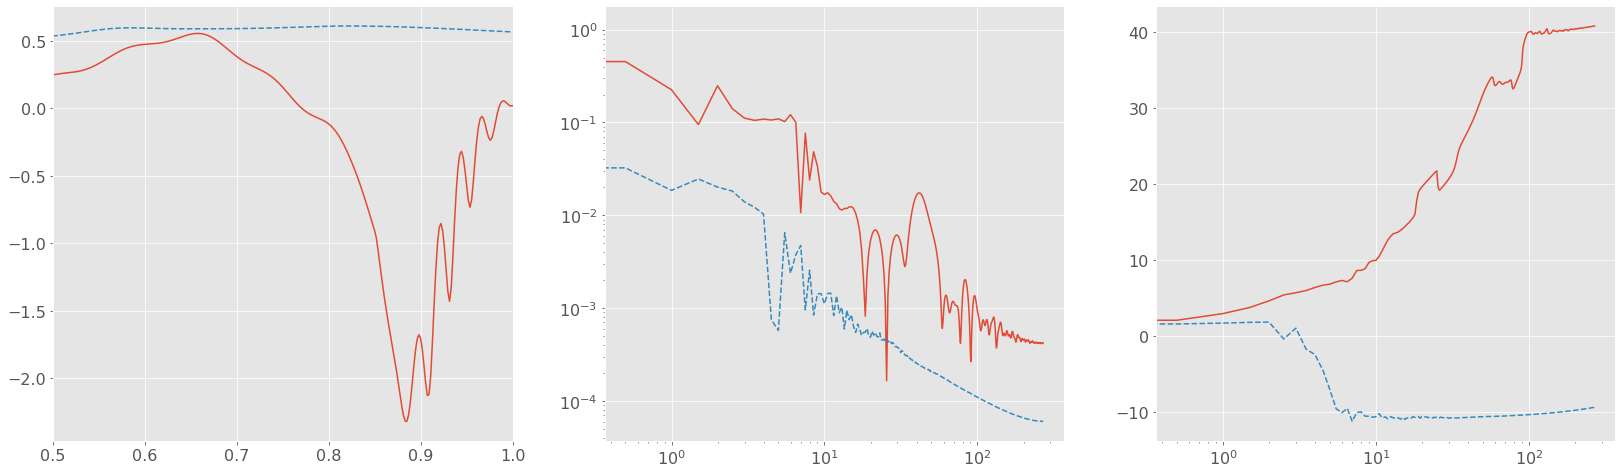

In [300]:
index=-1
print(f"s1x: {s1x_arr[index]}")
yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
xf, yf = compute_fft(common_times_scaled, amps_prime[index])
xfhat, yfhat = compute_fft(common_times_scaled, yhat[0])

plt.figure(figsize=(28, 8))
plt.subplot(1, 3, 1)
plt.plot(common_times_scaled, amps_prime[index], label='data')
plt.plot(common_times_scaled, yhat[0], ls='--', label='prediction')
# plt.xlim(-10, 60)
plt.xlim(0.5, 1)

plt.subplot(1, 3, 2)
plt.plot(xf, np.abs(yf), label='data')
plt.plot(xfhat, np.abs(yfhat), ls='--', label='prediction')
plt.yscale('log')
plt.xscale('log')

plt.subplot(1, 3, 3)
plt.plot(xf, np.unwrap(np.angle(yf)), label='data')
plt.plot(xfhat, np.unwrap(np.angle(yfhat)), ls='--', label='prediction')
# plt.yscale('log')
plt.xscale('log')

## now we have trained on one waveform lets use a larger training set with the pre-trained model

In [333]:
lr=1e-3
new_model= tf.keras.models.clone_model(single_case['model'])
optimizer = tf.keras.optimizers.Adam(lr)
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
new_model.set_weights(single_case['model'].get_weights())

In [334]:
# epochs = 200
# epochs = 600
epochs = 2000
# epochs = 4000
# epochs = 5000
# epochs = 10000


batch_size = X.shape[0]
# batch_size = X.shape[0]//2
# batch_size = X.shape[0]//4
# batch_size = X.shape[0]//8
# batch_size = X.shape[0]//16

# batch_size = 256

print(f"batch_size: {batch_size}")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95,
                              patience=40, min_lr=1e-4)


threshold = wispy.callbacks.ThresholdCallback(1e-6)
# callbacks = [reduce_lr, pugna.callbacks.PrintDot(), threshold]
# callbacks = [reduce_lr, PrintDot()]
callbacks = [pugna.callbacks.PrintDot(), threshold]

batch_size: 5395


In [335]:
starttime = datetime.datetime.now()

new_history = new_model.fit(
    X,
    y,
    epochs=epochs,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=0,
    sample_weight=sample_weight
)

endtime = datetime.datetime.now()
duration = endtime - starttime

print(f"\nThe time cost: {duration}")


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

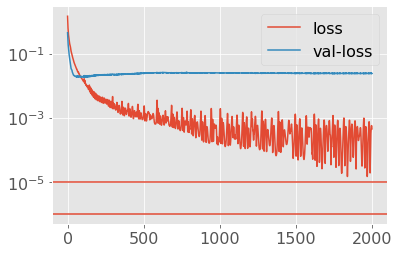

In [336]:
plt.figure()
plt.plot(new_history.history['loss'], label='loss')
plt.plot(new_history.history['val_loss'], label='val-loss')
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.axhline(1e-5)
plt.axhline(1e-6)

if 'lr' in new_history.history.keys():
    plt.figure()
    plt.plot(new_history.history['lr'], label='lr')
    plt.legend()
    plt.yscale('log')
    plt.xscale('log')

s1x: 0.0


(-10.0, 40.0)

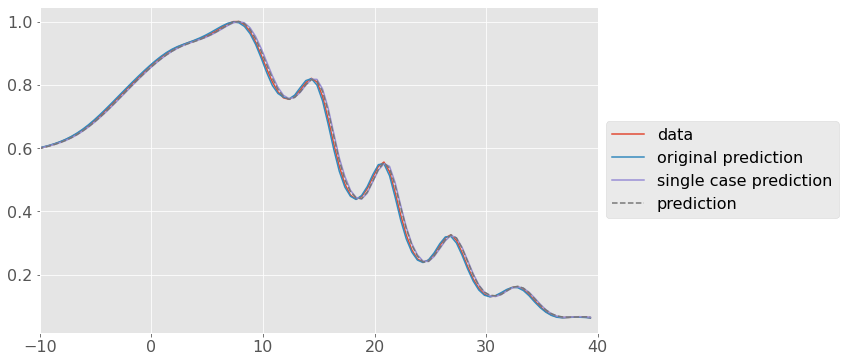

In [ ]:
index=0
print(f"s1x: {s1x_arr[index]}")
og_yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
single_case_yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
yhat = evaluate(s1x_arr[index], new_model, times=common_times_scaled)
plt.figure(figsize=(10, 6))
# plt.plot(common_times_scaled, amps_prime[index], label='data')
# plt.plot(common_times_scaled, yhat[0], label='prediction')
plt.plot(common_times, amps_prime[index], label='data')
plt.plot(common_times, og_yhat[0], label='original prediction')
plt.plot(common_times, single_case_yhat[0], label='single case prediction')
plt.plot(common_times, yhat[0], label='prediction', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-10, 40)

s1x: 0.0


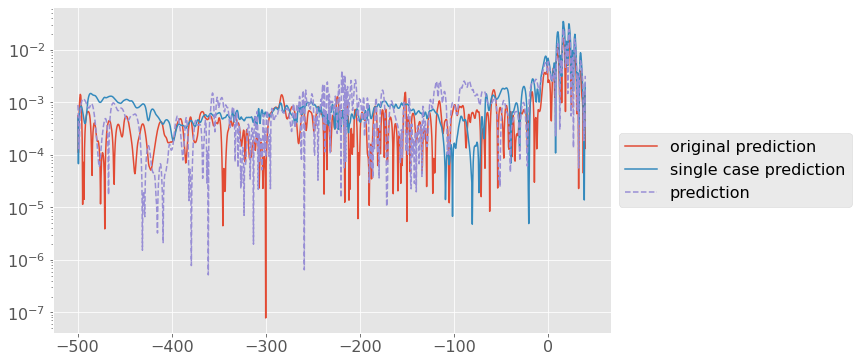

In [408]:
index=0
print(f"s1x: {s1x_arr[index]}")
og_yhat = evaluate(s1x_arr[index], model, times=common_times_scaled)
single_case_yhat = evaluate(s1x_arr[index], single_case['model'], times=common_times_scaled)
yhat = evaluate(s1x_arr[index], new_model, times=common_times_scaled)
plt.figure(figsize=(10, 6))
plt.plot(common_times, np.abs(amps_prime[index]-og_yhat[0]), label='original prediction')
plt.plot(common_times, np.abs(amps_prime[index]-single_case_yhat[0]), label='single case prediction')
plt.plot(common_times, np.abs(amps_prime[index]-yhat[0]), label='prediction', ls='--')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-10, 40)
plt.yscale('log')

It seems that just using the whole dataset was better than doing it hierachically